In [187]:
import numpy as np
import pandas as pd
import librosa
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import librosa.display

In [184]:
y,sr =librosa.load( './soyoung_songs/song_02.mp3')

In [185]:
print('Audio length (seconds): %.2f' % (len(y) / sr))

Audio length (seconds): 33.56


In [186]:
import IPython.display as ipd
ipd.Audio(y, rate=sr)

- 음악 그래프 <hr>

In [1]:


# plt.figure(figsize =(16,6))
# plt.plot(y)
# plt.title('Waveform')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.show()

Fourier Transform (푸리에 변환)
: 시간 영역 데이터를 주파수 영역으로 변경
time(시간) domain -> frequency (진동수)
- y축 : 주파수(로그 스케일)
-color축 : 데시벨(진폭)

In [2]:
# import numpy as np

# # n_fft : window size
# # 음성의 길이를 얼마만큼으로 자를 것인가? => window
# Fourier = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) 

# print(Fourier.shape)

# plt.figure(figsize=(16,6))
# plt.plot(Fourier)
# plt.show()


Spectogram : 시간에 따른 신호 주파수의 스펙트럼 그래프

In [3]:
# # amplitude(진폭) -> DB(데시벨)로 바꿔라
# DB = librosa.amplitude_to_db(Fourier, ref=np.max)

# plt.figure(figsize=(16,6))
# librosa.display.specshow(DB,sr=sr, hop_length=512, x_axis='time', y_axis='log')
# plt.colorbar()
# plt.show()

- Mel Spectogram : Spectogram의 y축을 Mel Scale로 변환한 것

In [4]:
# import matplotlib.pyplot as plt
# import librosa.display
# import numpy as np

# Mel = librosa.feature.melspectrogram(y=y, sr=sr)
# Mel_DB = librosa.amplitude_to_db(Mel, ref=np.max)

# plt.figure(figsize=(16, 6))
# librosa.display.specshow(Mel_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram')
# plt.show()


- Jazz와 HipHop 비교

In [5]:
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 지정
# file_path = '../datasets/dance/dance1.wav'

# # 오디오 파일 로드 및 잘라내기
# y, sr = librosa.load(file_path)
# y, _ = librosa.effects.trim(y)

# # Mel 스펙트로그램 계산
# S = librosa.feature.melspectrogram(y=y, sr=sr)
# S_DB = librosa.amplitude_to_db(S, ref=np.max)

# # 스펙트로그램 시각화
# plt.figure(figsize=(16, 6))
# librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel Spectrogram')
# plt.show()


- 오디오 특성 추출
- Tempo(BPM)

In [13]:
tempo , _ = librosa.beat.beat_track(y=y,sr=sr)     
print(tempo)

78.30255681818181


- Zero Crossing Rate 
: 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

In [14]:
# 0이 되는 선을 지나친 횟수
zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings)) # 음 <-> 양 이동한 횟수

[False False False ... False False False]
91203


In [14]:
# n0 = 9000
# n1 = 9080

# plt.figure(figsize=(16,6))
# plt.plot(y[n0:n1])
# plt.grid()
# plt.show()

In [16]:
 #n0 ~ n1 사이 zero crossings 
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

11


- 특징 추출
- Harmonic and Percussive Components
- Precussives : 리듬과 감정을 나타내는 충격파
- Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)

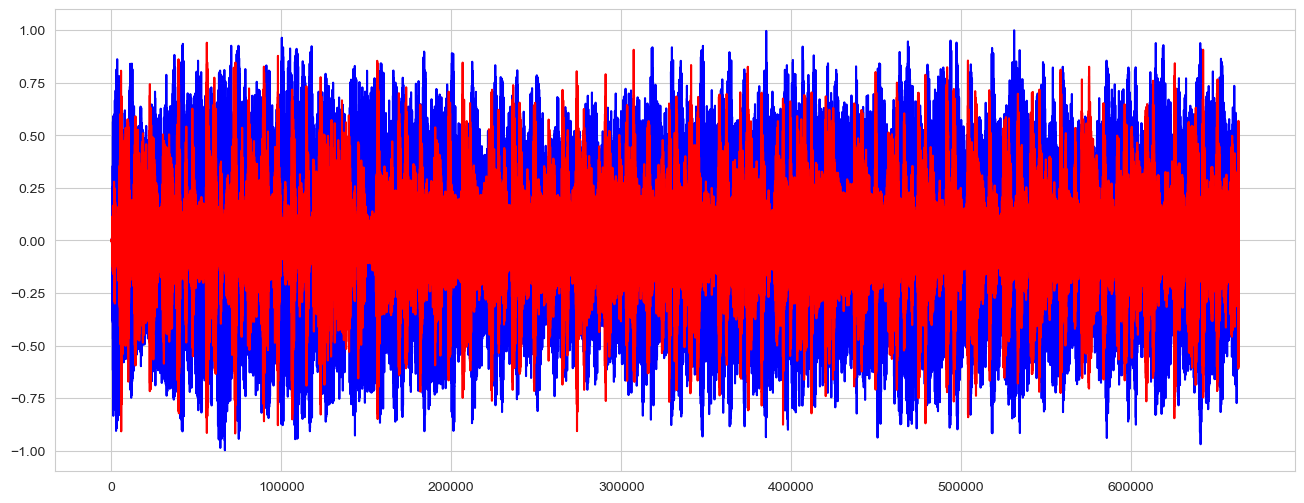

In [17]:
y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16,6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

Special Centroid
: 소리를 주파수로 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게중심"이 어딘지 알려주는 지표

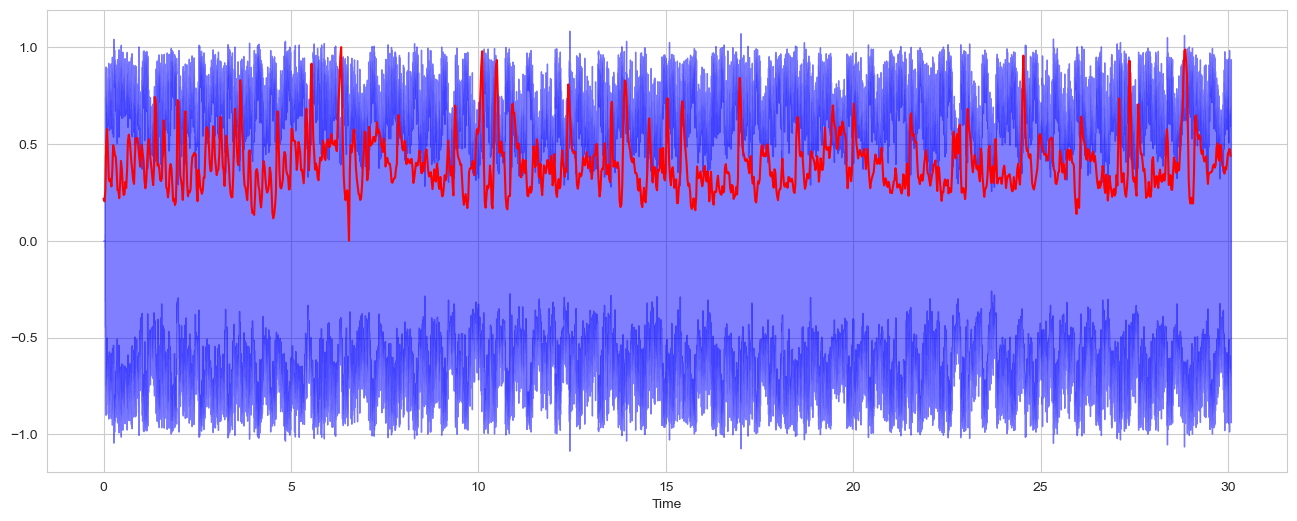

In [18]:
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

#Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
# sk.minmax_scale() : 최대 최소를 0 ~ 1 로 맞춰준다.
  return sklearn.preprocessing.minmax_scale(x, axis=axis) 

plt.figure(figsize=(16,6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()


Spectral Rolloff
- 총 스펙트럼 에너지 중 낮은 주파수(85%이하)에 얼마나 많이 집중되어 있는가
- 신호 모양을 측정

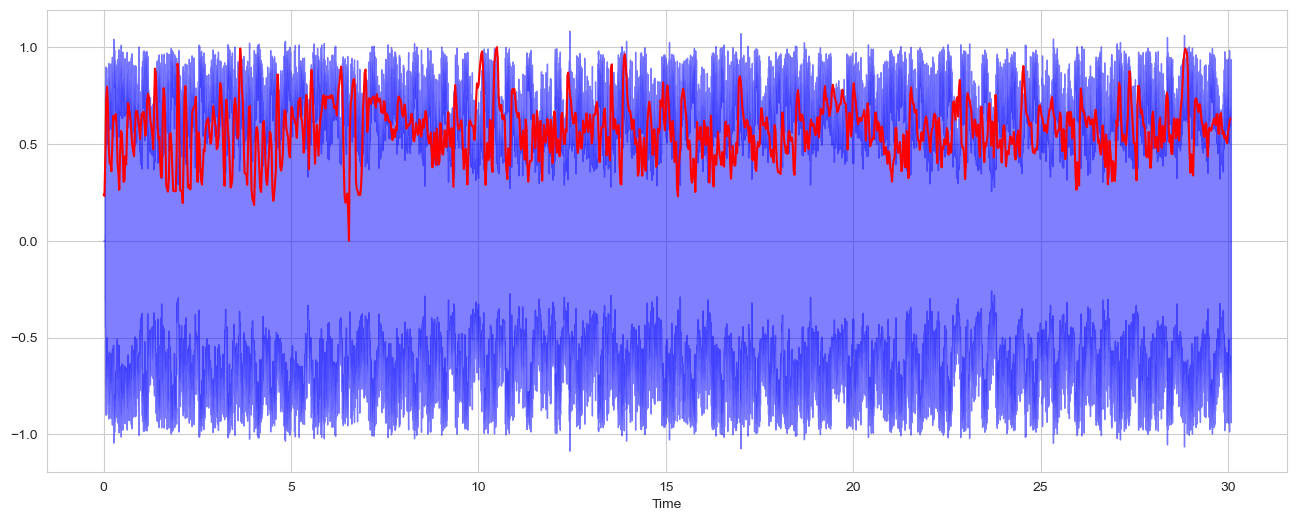

In [19]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

plt.figure(figsize=(16,6))
librosa.display.waveshow(y,sr=sr,alpha=0.5,color='b')
plt.plot(t, normalize(spectral_rolloff),color='r')
plt.show()

Mel-Frequency Cepstral Coefficients(MFCCs)
- 특징들의 작은 집합으로 스펙트럴 포곡선의 전체적인 모양을 축약
- 사람의 청각 구조를 반영하여 음성 정보 추출
- 1. 전체 오디오 신호를 일정 간격으로 나누고 푸리에 변환을 거쳐 스펙트로그램을 구함
- 2. 각 스펙트럼의 제곱인 파워 스펙트로그램에 Mel scale filter bank를 사용해 차원 수 줄임
- 3. cepstral 분석을 적용해 MFCC 구함

mean : 0.49
var : 0.03


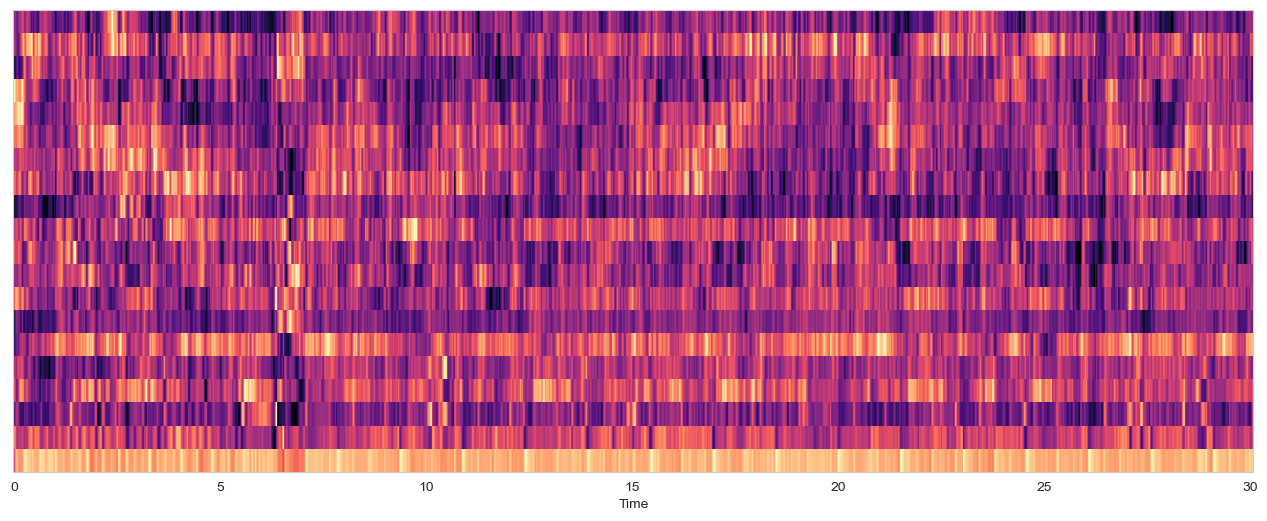

In [20]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)
mfccs = normalize(mfccs,axis=1)

print('mean : %.2f' % mfccs.mean())
print('var : %.2f' % mfccs.var())

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs,sr=sr, x_axis='time')
plt.show()

Chroma Frequencies
- 크로마는 인간 청각이 옥타브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지
- 크로마 특징은 음악의 흥미롭고 강렬한 표현

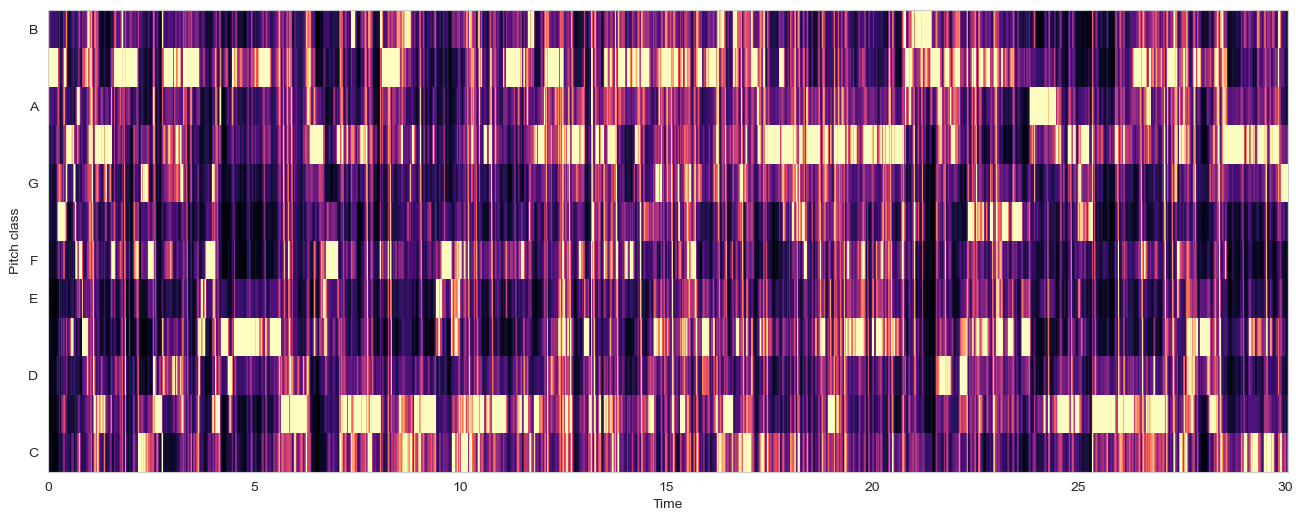

In [21]:
chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram,x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

음악 장르 분류
- 1) 데이터셋 로드

In [74]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')  # 그래프 테두리 모두 제거

In [15]:
genre_names = os.listdir('./sounds')
genre_names

['ballade', 'dance', 'trot']

In [ ]:
# import pandas as pd
# import librosa
# import numpy as np
# import os

# import sklearn

# def normalize(x, axis=0):
#     return sklearn.preprocessing.minmax_scale(x, axis=axis) 

# # DataFrame을 저장할 빈 리스트 생성
# df_list = []

# for genre_name in genre_names:
#     # WAV 파일이 있는 디렉토리 경로
#     wav_dir = f'./sounds/{genre_name}/'

#     # 모든 WAV 파일 리스트
#     wav_files = os.listdir(wav_dir)

#     # 각 WAV 파일에 대해 특징 계산 및 DataFrame에 추가
#     for wav_file in wav_files:
#         # WAV 파일 로드
#         y, sr = librosa.load(os.path.join(wav_dir, wav_file))
        
#         # MFCCs 계산
#         mfccs = librosa.feature.mfcc(y=y, sr=sr)
#         mfccs = normalize(mfccs, axis=1)
#         mfcc_mean_list = []
#         mfcc_var_list = []
#         for i, mfcc_line in enumerate(mfccs[::-1]):
#             mfcc_mean_list.append(np.mean(mfcc_line))
#             mfcc_var_list.append(np.var(mfcc_line))
#             if i == 9:
#                 break
        
#         # Spectral Centroids 계산
#         spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
#         print(spectral_centroids.shape)
        
#         # Spectral Rolloff 계산
#         spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
#         print(spectral_rolloff.shape)
        
#         # Chromagram 계산
#         chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
#         print(chromagram.shape)
        
#         # Zero-Crossing Rate (제로 크로싱 비율)
#         zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0]
#         print(zero_crossing_rate.shape)

#         # Root Mean Square (RMS) Energy (평균 제곱근 에너지)
#         rms_energy = librosa.feature.rms(y=y)[0]
#         print(rms_energy.shape)

#         # Spectral Bandwidth (주파수 대역폭)
#         spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
#         print(spectral_bandwidth.shape)

#         # Spectral Contrast (주파수 대비)
#         spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
#         print(spectral_contrast.shape)

#         # Spectral Flatness (주파수 평평도)
#         spectral_flatness = librosa.feature.spectral_flatness(y=y)
#         print(spectral_flatness.shape)
        
#         # BPM 계산 
#         tempo , _ = librosa.beat.beat_track(y=y,sr=sr)     
        
#         # 하모니(음색) -> 코러스 좀... / 충격파(둥둥)
#         harmonic, percussive = librosa.effects.hpss(y=y)
#         print(harmonic.shape)
        
        
#         # 각 특징들의 평균과 분산 계산
#         data = {
#             'Filename': os.path.join(wav_dir, wav_file),
#             'MFCC_Mean': [np.mean(mfccs)],
#             'MFCC_Var': [np.var(mfccs)],
#             'Chromagram_Mean': [np.mean(chromagram)],
#             'Chromagram_Var': [np.var(chromagram)],
#             'Spectral_Centroids_Mean': [np.mean(spectral_centroids)],
#             'Spectral_Centroids_Var': [np.var(spectral_centroids)],
#             'Spectral_Rolloff_Mean': [np.mean(spectral_rolloff)],
#             'Spectral_Rolloff_Var': [np.var(spectral_rolloff)],
#             'Zero_Crossing_Rate': [np.mean(zero_crossing_rate)],
#             'RMS_Energy_Mean': [np.mean(rms_energy)],
#             'RMS_Energy_Var': [np.var(rms_energy)],
#             'Spectral_Bandwidth_Mean': [np.mean(spectral_bandwidth)],
#             'Spectral_Bandwidth_Var': [np.var(spectral_bandwidth)],
#             'Spectral_Contrast_Mean': [np.mean(spectral_contrast)],
#             'Spectral_Contrast_Var': [np.var(spectral_contrast)],
#             'Spectral_Flatness_Mean': [np.mean(spectral_flatness)],
#             'Spectral_Flatness_Var': [np.var(spectral_flatness)],
#             'Tempo': [tempo],
            
#             "harmony_mean" : [harmonic.mean()],
#             "harmony_var" : [harmonic.var()],
#             "precussive_mean" : [percussive.mean()],
#             "percussive_var" : [percussive.var()],
            
            
#             # 'mfcc_mean_0' : [mfcc_mean_list[0]],
#             # 'mfcc_mean_1' : [mfcc_mean_list[1]],
#             # 'mfcc_mean_2' : [mfcc_mean_list[2]],
#             # 'mfcc_mean_3' : [mfcc_mean_list[3]],
#             # 'mfcc_mean_4' : [mfcc_mean_list[4]],
#             # 'mfcc_mean_5' : [mfcc_mean_list[5]],
#             # 'mfcc_mean_6' : [mfcc_mean_list[6]],
#             # 'mfcc_mean_7' : [mfcc_mean_list[7]],
#             # 'mfcc_mean_8' : [mfcc_mean_list[8]],
#             # 'mfcc_mean_9' : [mfcc_mean_list[9]],
            
#             # 'mfcc_var_0' : [mfcc_var_list[0]],
#             # 'mfcc_var_1' : [mfcc_var_list[1]],
#             # 'mfcc_var_2' : [mfcc_var_list[2]],
#             # 'mfcc_var_3' : [mfcc_var_list[3]],
#             # 'mfcc_var_4' : [mfcc_var_list[4]],
#             # 'mfcc_var_5' : [mfcc_var_list[5]],
#             # 'mfcc_var_6' : [mfcc_var_list[6]],
#             # 'mfcc_var_7' : [mfcc_var_list[7]],
#             # 'mfcc_var_8' : [mfcc_var_list[8]],
#             # 'mfcc_var_9' : [mfcc_var_list[9]],
            
#             'label': genre_name
#         }
        
#         # 데이터를 DataFrame으로 변환하여 리스트에 추가
#         df_list.append(pd.DataFrame(data))       
        
#         break ####################################################################                   

# # 모든 DataFrame을 하나의 큰 DataFrame으로 결합
# combined_df = pd.concat(df_list, ignore_index=True)

# # CSV 파일로 저장 ################################################################################################
# # output_csv = './csv_data/genre.csv'
# # combined_df.to_csv(output_csv, index=False)
# # print(f'CSV 파일 저장: {output_csv}')


In [183]:
import pandas as pd
import librosa
import numpy as np
import os

import sklearn

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis) 

# DataFrame을 저장할 빈 리스트 생성
df_list = []

for genre_name in genre_names:
    # WAV 파일이 있는 디렉토리 경로
    wav_dir = f'./sounds/{genre_name}/'

    # 모든 WAV 파일 리스트
    wav_files = os.listdir(wav_dir)

    # 각 WAV 파일에 대해 특징 계산 및 DataFrame에 추가
    for wav_file in wav_files:
        # WAV 파일 로드
        y, sr = librosa.load(os.path.join(wav_dir, wav_file))
        
        # MFCCs 계산
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        mfccs = normalize(mfccs, axis=1)
        mfcc_mean_list = []
        mfcc_var_list = []
        for i, mfcc_line in enumerate(mfccs[::-1]):
            mfcc_mean_list.append(np.mean(mfcc_line))
            mfcc_var_list.append(np.var(mfcc_line))
            if i == 9:
                break
        
        # Spectral Centroids 계산
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        
        # Spectral Rolloff 계산
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        
        # Chromagram 계산
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
        
        # Zero-Crossing Rate (제로 크로싱? 비율)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0]

        # Root Mean Square (RMS) Energy (평균 제곱근 에너지)
        rms_energy = librosa.feature.rms(y=y)[0]

        # Spectral Bandwidth (주파수 대역폭)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]

        # Spectral Contrast (주파수 대비)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Spectral Flatness (주파수 평평도)
        spectral_flatness = librosa.feature.spectral_flatness(y=y)
        
        # BPM 계산 
        tempo , _ = librosa.beat.beat_track(y=y,sr=sr)     
        
        # 하모니(음색) -> 코러스 좀... / 충격파(둥둥)
        harmonic, percussive = librosa.effects.hpss(y=y)
        
        
        # 각 특징들의 평균과 분산 계산
        data = {
            # 파일 경로
            'Filename': os.path.join(wav_dir, wav_file),
            # 특성
            'MFCC_Mean': [np.mean(mfccs)],
            'MFCC_Var': [np.var(mfccs)],
            'Chromagram_Mean': [np.mean(chromagram)],
            'Chromagram_Var': [np.var(chromagram)],
            'Spectral_Centroids_Mean': [np.mean(spectral_centroids)],
            'Spectral_Centroids_Var': [np.var(spectral_centroids)],
            'Spectral_Rolloff_Mean': [np.mean(spectral_rolloff)],
            'Spectral_Rolloff_Var': [np.var(spectral_rolloff)],
            'Zero_Crossing_Rate': [np.mean(zero_crossing_rate)],
            'RMS_Energy_Mean': [np.mean(rms_energy)],
            'RMS_Energy_Var': [np.var(rms_energy)],
            'Spectral_Bandwidth_Mean': [np.mean(spectral_bandwidth)],
            'Spectral_Bandwidth_Var': [np.var(spectral_bandwidth)],
            'Spectral_Contrast_Mean': [np.mean(spectral_contrast)],
            'Spectral_Contrast_Var': [np.var(spectral_contrast)],
            'Spectral_Flatness_Mean': [np.mean(spectral_flatness)],
            'Spectral_Flatness_Var': [np.var(spectral_flatness)],
            'Tempo': [tempo],
            "harmony_mean" : [harmonic.mean()],
            "harmony_var" : [harmonic.var()],
            "precussive_mean" : [percussive.mean()],
            "percussive_var" : [percussive.var()],
            # 정답!
            'label': genre_name
        }
        
        # 데이터를 DataFrame으로 변환하여 리스트에 추가
        df_list.append(pd.DataFrame(data))                          

# 모든 DataFrame을 하나의 큰 DataFrame으로 결합
combined_df = pd.concat(df_list, ignore_index=True)

# CSV 파일로 저장
output_csv = './csv_data/genre.csv'
combined_df.to_csv(output_csv, index=False)
print(f'CSV 파일 저장: {output_csv}')


(1378,)
(1378,)
(12, 1378)
(1378,)
(1378,)
(1378,)
(7, 1378)
(1, 1378)
(705184,)
(1296,)
(1296,)
(12, 1296)
(1296,)
(1296,)
(1296,)
(7, 1296)
(1, 1296)
(663330,)
(1292,)
(1292,)
(12, 1292)
(1292,)
(1292,)
(1292,)
(7, 1292)
(1, 1292)
(661500,)


In [188]:
genreDF = pd.read_csv('./csv_data/genre.csv', index_col=0)
genreDF

,MFCC_Mean,MFCC_Var,Chromagram_Mean,Chromagram_Var,Spectral_Centroids_Mean,Spectral_Centroids_Var,Spectral_Rolloff_Mean,Spectral_Rolloff_Var,Zero_Crossing_Rate,RMS_Energy_Mean,...,Spectral_Contrast_Mean,Spectral_Contrast_Var,Spectral_Flatness_Mean,Spectral_Flatness_Var,Tempo,harmony_mean,harmony_var,precussive_mean,percussive_var,label
Filename,,,,,,,,,,,,,,,,,,,,,
./sounds/ballade/balad1.wav,0.492151,0.030902,0.270474,0.089341,2387.264407,346469.319717,5625.463371,1.714409e+06,0.102092,0.147399,...,23.899367,108.830845,0.013874,0.000323,135.999178,-1.811814e-05,0.015477,-0.000122,0.003027,ballade
./sounds/ballade/balad10.wav,0.494340,0.029432,0.297158,0.089418,2760.713355,874983.475055,6078.346578,2.545436e+06,0.128119,0.132589,...,23.247629,112.121133,0.026901,0.001300,64.599609,5.533915e-07,0.011543,0.000022,0.003097,ballade
./sounds/ballade/balad100.wav,0.494599,0.033184,0.269402,0.092836,2282.748033,741578.172628,5864.322873,4.915561e+06,0.083171,0.164694,...,25.976078,114.427656,0.007770,0.000302,135.999178,-2.589973e-05,0.027806,-0.000105,0.001436,ballade
./sounds/ballade/balad11.wav,0.522101,0.035166,0.312291,0.089319,2553.538250,614269.047823,5838.439696,1.723735e+06,0.112643,0.164127,...,21.968064,108.946196,0.024021,0.000752,99.384014,-1.333861e-05,0.013958,-0.000127,0.006351,ballade
./sounds/ballade/balad12.wav,0.503501,0.031803,0.329324,0.090454,2637.886078,398300.408776,5882.086706,1.513782e+06,0.116313,0.121782,...,23.219600,121.811586,0.021042,0.000472,75.999540,-1.170401e-03,0.010383,-0.001472,0.002227,ballade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
./sounds/trot/trot95.wav,0.511586,0.034614,0.269811,0.087703,2258.633153,540211.108915,4959.070013,2.232002e+06,0.095559,0.331198,...,25.026332,120.836173,0.010748,0.000261,92.285156,-2.861888e-07,0.082936,-0.000344,0.011260,trot
./sounds/trot/trot96.wav,0.556711,0.027494,0.342435,0.089165,2840.946917,317913.024315,5955.847319,7.630778e+05,0.143662,0.321460,...,22.523009,129.750997,0.037661,0.001205,135.999178,1.792903e-05,0.056379,-0.000007,0.020331,trot
./sounds/trot/trot97.wav,0.522001,0.029554,0.346450,0.088657,2582.017841,814742.649320,5591.491189,2.057968e+06,0.110160,0.332125,...,23.360787,121.238859,0.020460,0.000775,151.999081,-4.472127e-05,0.078390,-0.000399,0.013592,trot


In [189]:
labels = genreDF["label"]
genreDF = genreDF.drop(["label"], axis=1)

In [190]:
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# # Read data
# data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
# labels = data[['label']]

# Drop labels from original dataframe
# data = data.drop(columns=['length','label'])
# data.head()

# prerocessing.scale => 모든 축을 따라서 standardize
data_scaled=preprocessing.scale(genreDF)
# print('Scaled data type:', type(data_scaled))

In [191]:
# 코사인 유사도 분석 
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (300, 300)


Filename,./sounds/ballade/balad1.wav,./sounds/ballade/balad10.wav,./sounds/ballade/balad100.wav,./sounds/ballade/balad11.wav,./sounds/ballade/balad12.wav,./sounds/ballade/balad13.wav,./sounds/ballade/balad14.wav,./sounds/ballade/balad15.wav,./sounds/ballade/balad16.wav,./sounds/ballade/balad17.wav,...,./sounds/trot/trot90.wav,./sounds/trot/trot91.wav,./sounds/trot/trot92.wav,./sounds/trot/trot93.wav,./sounds/trot/trot94.wav,./sounds/trot/trot95.wav,./sounds/trot/trot96.wav,./sounds/trot/trot97.wav,./sounds/trot/trot98.wav,./sounds/trot/trot99.wav
Filename,,,,,,,,,,,,,,,,,,,,,
./sounds/ballade/balad1.wav,1.000000,0.344076,0.514061,0.370290,0.371184,0.586203,0.547171,0.699323,0.382157,0.598897,...,-0.203875,-0.528057,-0.543091,-0.150033,0.144084,0.022647,-0.423281,-0.294187,-0.487901,-0.500106
./sounds/ballade/balad10.wav,0.344076,1.000000,0.257406,0.544166,0.571205,0.098966,0.159934,0.130427,-0.066109,0.426956,...,0.158500,-0.523327,-0.158138,0.006757,0.134322,-0.046077,-0.347210,-0.357526,-0.112257,-0.462275
./sounds/ballade/balad100.wav,0.514061,0.257406,1.000000,0.088988,0.065770,0.559469,0.510627,0.550864,0.294863,0.663383,...,-0.297511,-0.792583,-0.473865,-0.350478,0.578752,0.285788,-0.652411,-0.060675,-0.671431,-0.605436
./sounds/ballade/balad11.wav,0.370290,0.544166,0.088988,1.000000,0.532661,-0.058431,-0.192127,0.117403,0.042030,0.280073,...,0.144926,-0.186055,0.029504,0.215958,-0.092275,0.018093,-0.189024,-0.349263,-0.053719,-0.351994
./sounds/ballade/balad12.wav,0.371184,0.571205,0.065770,0.532661,1.000000,0.102034,0.020025,0.162195,0.115204,0.148169,...,0.195149,-0.193489,-0.085054,0.162492,-0.205396,0.048858,-0.179045,-0.421030,-0.119258,-0.211903


In [198]:
def find_similar_songs(name, sim_df_names):
    indices = sim_df_names[sim_df_names.index.str.endswith(name)].index
    # print(list(indices)) # ['./sounds/dance/dance3.wav']
    
    file_path = list(indices)[0]
    # 비슷한 거 찾고 정렬 -> ascending 중요
    series = sim_df_names[file_path].sort_values(ascending = False)
    
    # 자기자신 제외 
    series = series.drop(file_path)
    
    # 제일 유사한 5개 
    print("내 음악 : ", name)
    print("유사한 음악")
    print(series.head(5))

In [201]:
find_similar_songs('trot5.wav', sim_df_names) 

내 음악 :  trot5.wav
유사한 음악
Filename
./sounds/trot/trot18.wav    0.918261
./sounds/trot/trot20.wav    0.779123
./sounds/trot/trot24.wav    0.717591
./sounds/trot/trot16.wav    0.713232
./sounds/trot/trot46.wav    0.680030
Name: ./sounds/trot/trot5.wav, dtype: float64


# feature와 target 분리

In [157]:
genreDF = pd.read_csv('./csv_data/genre.csv', index_col=0)

targetDF = genreDF['label']
featureDF = genreDF.drop(columns=['label'])
print('featureDF',featureDF)
print('targetDF',targetDF)

featureDF                                MFCC_Mean  MFCC_Var  Chromagram_Mean  \
Filename                                                              
./sounds/ballade/balad1.wav     0.492151  0.030902         0.270474   
./sounds/ballade/balad10.wav    0.494340  0.029432         0.297158   
./sounds/ballade/balad100.wav   0.494599  0.033184         0.269402   
./sounds/ballade/balad11.wav    0.522101  0.035166         0.312291   
./sounds/ballade/balad12.wav    0.503501  0.031803         0.329324   
...                                  ...       ...              ...   
./sounds/trot/trot95.wav        0.511586  0.034614         0.269811   
./sounds/trot/trot96.wav        0.556711  0.027494         0.342435   
./sounds/trot/trot97.wav        0.522001  0.029554         0.346450   
./sounds/trot/trot98.wav        0.529830  0.029506         0.365747   
./sounds/trot/trot99.wav        0.541444  0.027917         0.379240   

                               Chromagram_Var  Spectral_Centroids_

- Train / Test 분할

In [158]:
X_train , X_test , y_train, y_test = train_test_split(featureDF,targetDF,test_size=0.2,random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(240, 22) (240,)
(60, 22) (60,)


- 모델 구축

RandomForest

In [159]:
# Random Forest 모델 생성
RFmodel = RandomForestClassifier(max_depth=10)

# 모델 훈련
RFmodel.fit(X_train, y_train)

# 테스트 데이터로 예측
predictions = RFmodel.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# 정밀도 계산
precision = precision_score(y_test, predictions, average="macro")

# 재현율 계산
recall = recall_score(y_test, predictions, average="macro")

# F1 점수 계산
f1 = f1_score(y_test, predictions, average="macro")

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9
Precision: 0.9015737874097006
Recall: 0.9034090909090909
F1 Score: 0.9000610559465279


# XGboost

In [160]:
from xgboost import XGBClassifier # XGboost

In [171]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
enc_y = encoder.fit_transform(y_train)

# 객체 생성
xgb_model = XGBClassifier(n_estimators=100)
xgb_model.fit(X_train, enc_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [176]:
list(encoder.classes_)

['ballade', 'dance', 'trot']

In [172]:
# 테스트 데이터로 예측
predictions = xgb_model.predict(X_test)

enc_y = encoder.transform(y_test)
# 정확도 평가
accuracy = accuracy_score(enc_y, predictions)
print("Accuracy:", accuracy)

# 정밀도 계산
precision = precision_score(enc_y, predictions, average="macro")

# 재현율 계산
recall = recall_score(enc_y, predictions, average="macro")

# F1 점수 계산
f1 = f1_score(enc_y, predictions, average="macro")

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9
Precision: 0.9082894736842104
Recall: 0.9034090909090909
F1 Score: 0.9030552672548002


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

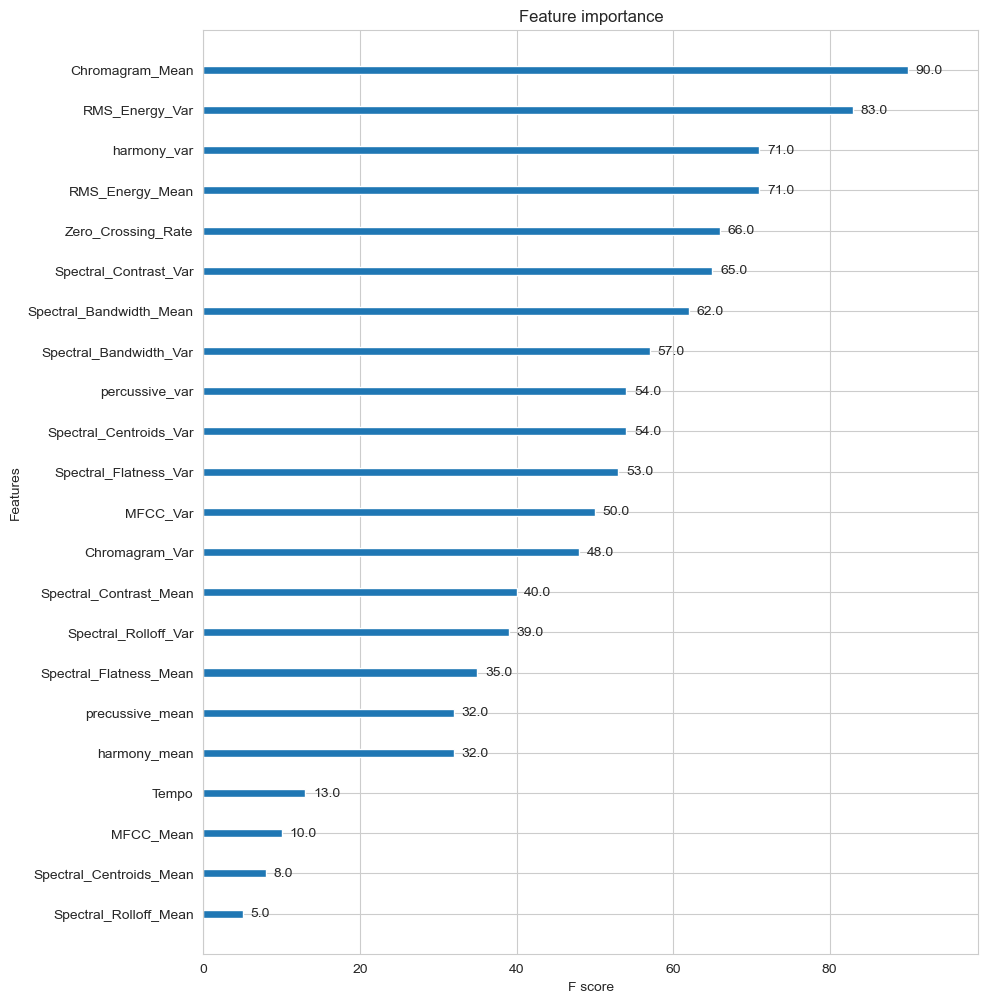

In [173]:
# 특성 중요도 시각화
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax) 

In [177]:
import joblib

# 모델 저장
joblib.dump(xgb_model, 'xgb_model.pkl')

# 저장된 모델 불러오기
# loaded_model = joblib.load('xgb_model.pkl')

['xgb_model.pkl']

In [178]:
import joblib

# LabelEncoder 저장
joblib.dump(encoder, 'label_encoder.pkl')

# 저장된 LabelEncoder 불러오기
# loaded_encoder = joblib.load('label_encoder.pkl')


['label_encoder.pkl']